# import

In [1]:
### try to use class, combine all code of plot of annular mode 
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

## cal $\overline{v'q'} = {-\partial (\overline{u'v'}) \over \partial y} $ + $\partial ({f_0 \over N^2} \overline{v'b'}) \over \partial z$

In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        
        self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        self.Uzm   = np.nanmean(self.u, axis=3)
        self.Vzm   = np.nanmean(self.v, axis=3)
        self.THzm  = np.nanmean(self.theta, axis=3)
        self.Pzm   = np.nanmean(self.p, axis=3)
        self.Tzm   = np.nanmean(self.t, axis=3)
        
        ### anamoly
        self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        self.THzmtm = np.nanmean(self.THzm, axis=0)
        self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        self.Vza     = np.zeros(self.u.shape)
        self.Uza     = np.zeros(self.u.shape)
        self.THETAza = np.zeros(self.u.shape)
        self.Pza     = np.zeros(self.u.shape)
        self.Tza     = np.zeros(self.t.shape)

        for i in range(0,128):
            self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
            self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
            self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
            self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
            self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def _get_len_day(self, var):
        return int(len(var[:,0,0,0]))
    
    def _cal_z(self):
        self.z = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.z[:,i,:,:] = self.Rd*np.nanmean(self.t[:,0:i+1,:,:], axis=1)/self.g * np.log(self.ps[:,0,:,:] / self.p[:,i+1,:,:])
        self.z[:, 0,:,:] = self.Rd*np.nanmean(self.t[:,0: 1,:,:], axis=1)/self.g * np.log(self.ps[:,0,:,:] / self.p[:,1,:,:])
        self.z[:,-1,:,:] = self.Rd*np.nanmean(self.t[:,:,:,:], axis=1)/self.g * np.log(self.ps[:,0,:,:] / self.p[:,-1,:,:])
        return self.z
    # def _cal_basic(self):
        # return np.asarray(self.u), np.asarray(self.Uza), np.asarray(self.Vza), self.yy, self.sigma_mean2, np.asarray(self.THETAza)
    
    def _cooridate(self):
        return self.yy, self.sigma_mean2
    
    def _cal_EMF_and_EMF_div(self):
        self.day = self._get_len_day(self.u)
        self.M   = self.Uza * self.Vza
        self.Mzm = np.nanmean(self.M, axis=(3))

        for i in range(1,64-1):
            self.Mzm[:,:,i] = self.cy[i]**0.5 * self.Mzm[:,:,i]

        self.dmdy = np.zeros(((self.day,20,64)))
        for i in range(1,64-1):
            self.dmdy[:,:,i] = -(self.Mzm[:,:,i+1] - self.Mzm[:,:,i-1]) / (self.a * (self.yd[i+1] - self.yd[i-1]))
        self.dmdy[:,:, 0] = -(self.Mzm[:,:, 1] - self.Mzm[:,:, 0]) / (self.a*(self.yd[ 1] - self.yd[ 0]))
        self.dmdy[:,:,-1] = -(self.Mzm[:,:,-1] - self.Mzm[:,:,-2]) / (self.a*(self.yd[-1] - self.yd[-2]))
        return self.Mzm, self.dmdy
    
    def _cal_buoyancy_and_f0(self):
        # self.u, self.Uza, self.Vza, self.yy, self.sigma_mean2, self.THETAza =  self._cal_basic() 
        # self.yd  = self._cooridate()
        self.bza = self.THETAza / np.nanmean(self.theta, axis=0) * 9.81
        self.f0  = 2 * 7.292E-5 * np.sin(self.yd)
        return self.bza, self.f0
    
    def _extrapolate_z_and_theta(self):
        # self.u, self.Uza, self.Vza, self.yy, self.sigma_mean2, self.THETAza =  self._cal_basic() 
        self.day = self._get_len_day(self.u)
        self.z = self._cal_z()
        
        self.z_new     = np.zeros((((self.day,22,64,128))))
        self.theta_new = np.zeros((((self.day,22,64,128))))

        for i in range(self.day):
            for j in range(64):
                  for k in range(128):
                    self.fe                 = interp1d(np.linspace(0,20,20),self.z[i,:,j,k],  fill_value='extrapolate')
                    self.z_new[i,:,j,k]     = self.fe(np.linspace(-1,21,22))
                    self.fe                 = interp1d(np.linspace(0,20,20),self.theta[i,:,j,k],  fill_value='extrapolate')
                    self.theta_new[i,:,j,k] = self.fe(np.linspace(-1,21,22))
        print("extrapolate done!")
        return self.z_new, self.theta_new
    
    def _cal_N_square_z_new(self):
        self.day = self._get_len_day(self.u)
        self.z_new, self.theta_new = self._extrapolate_z_and_theta()
        self.N_square   = np.zeros(((self.day,20,64,128)))
        for i in range(1,20-1):
            self.N_square[:,i,:,:]   = 9.81 / self.theta[:,i,:,:] * (self.theta[:,i+1,:,:] - self.theta[:,i-1,:,:]) / (self.z[:,i+1,:,:]-self.z[:,i-1,:,:]) # original is partial z, but Dycore is on pressure (sigma) coord. so add minus
        self.N_square[:, 0,:,:] = 9.81 / self.theta_new[:, 1,:,:]   * (self.theta_new[:, 2,:] - self.theta_new[:, 0,:,:]) / (self.z_new[:, 2,:,:]-self.z_new[:, 0,:,:])
        self.N_square[:,19,:,:] = 9.81 / self.theta_new[:,21,:,:] * (self.theta_new[:,21,:,:] - self.theta_new[:,18,:,:]) / (self.z_new[:,21,:,:]-self.z_new[:,18,:,:])
        return self.N_square, self.z_new, self.theta_new
    
    def _cal_MHF_and_MHF_f(self):
        self.N_square, self.z_new, self.theta_new = self._cal_N_square_z_new()
        self.bza, self.f0 = self._cal_buoyancy_and_f0()
        self.vpbp = np.nanmean(self.Vza * self.bza, axis=3)
        self.MHF = np.nanmean(self.Vza * self.bza, axis=3) / np.nanmean(self.N_square, axis=3)
        self.MHF_f = np.zeros(self.MHF.shape) # mean meridional heat flux 
        self.p_mean = np.nanmean(self.p, axis=3)
        for i in range(64):
            self.MHF_f[:,:,i] = self.MHF[:,:,i] * self.f0[i]
        return self.MHF, self.MHF_f, self.z_new, self.theta_new, self.vpbp
    
    ### v'q' = -dmdy + d(f_0 * v'b' / N^2) / dz
    # set q2 = d(f_0 * v'b' / N^2) / dz
    def cal_q2(self):
        self.z               = self._cal_z()
        self.bza, self.f0    = self._cal_buoyancy_and_f0()
        self.MHF, self.MHF_f, self.z_new, self.theta_new, self.vpbp = self._cal_MHF_and_MHF_f()
        self.q2              = np.zeros(((self._get_len_day(self.u),20,64)))
        for i in range(1,20-1):
            # z = Rd*np.nanmean(t[:,0:i,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
            self.q2[:,i,:] = (self.MHF_f[:,i+1,:] - self.MHF_f[:,i-1,:])  / np.nanmean(self.z[:,i+1,:,:]-self.z[:,i-1,:,:], axis=(0,2)) 
        return self.q2, self.MHF, self.MHF_f, self.z_new, self.theta_new
    # @abstractclassmethod




## cal cross spectrum => $(i\omega + {1 \over \tau}) = {MZ^* \over ZZ^*}$

In [3]:
class Global_cross_spectrum_edit_EOF_back_usingT:
    def __init__(self, file, MHF, MHF_f, z_new, theta_new, z, q2, dmdy):
        self.ds                    = h5py.File(file, "r")
        self.MHF, self.MHF_f       = MHF, MHF_f
        self.z_new, self.theta_new = z_new, theta_new
        self.z                     = z
        self.q2                    = q2
        self.dmdy                  = dmdy

        ###
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        
        self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        self.Uzm   = np.nanmean(self.u, axis=3)
        self.Vzm   = np.nanmean(self.v, axis=3)
        self.THzm  = np.nanmean(self.theta, axis=3)
        self.Pzm   = np.nanmean(self.p, axis=3)
        self.Tzm   = np.nanmean(self.t, axis=3)
        
        ### anamoly
        self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        self.THzmtm = np.nanmean(self.THzm, axis=0)
        self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        self.Vza     = np.zeros(self.u.shape)
        self.Uza     = np.zeros(self.u.shape)
        self.THETAza = np.zeros(self.u.shape)
        self.Pza     = np.zeros(self.u.shape)
        self.Tza     = np.zeros(self.t.shape)

        for i in range(0,128):
            self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
            self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
            self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
            self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
            self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan
        ###
        
    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def _get_len_day(self, var):
        return int(len(var[:,0,0,0]))
    
    def _cooridate(self):
        return self.yy, self.sigma_mean2
    
    def _cal_f0(self):
        # self.u, self.Uza, self.Vza, self.yy, self.sigma_mean2, self.THETAza =  self._cal_basic() 
        # self.yd  = self._cooridate()
        self.f0  = 2 * 7.292E-5 * np.sin(self.yd)
        return self.f0
    
    def _cal_z(self):
        self.z = np.zeros(self.u.shape)
        for i in range(1,20-1):
            self.z[:,i,:,:] = self.Rd*np.nanmean(self.t[:,0:i+1,:,:], axis=1)/self.g * np.log(self.ps[:,0,:,:] / self.p[:,i+1,:,:])
        self.z[:, 0,:,:] = self.Rd*np.nanmean(self.t[:,0: 1,:,:], axis=1)/self.g * np.log(self.ps[:,0,:,:] / self.p[:,1,:,:])
        self.z[:,-1,:,:] = self.Rd*np.nanmean(self.t[:,:,:,:], axis=1)/self.g * np.log(self.ps[:,0,:,:] / self.p[:,-1,:,:])
        return self.z
    
    def _cal_basic2(self): 
        self.day = self._get_len_day(self.u)
        self.VHF = np.zeros(((self.day,20,64))) # vertical heat flux
        for i in range(1,20-1):
            self.VHF[:,i,:] = (self.MHF[:,i+1,:] - self.MHF[:,i-1,:])  / np.nanmean(self.z[:,i+1,:,:]-self.z[:,i-1,:,:], axis=(2)) 
        # VHF[ :,0,:] = (MHF_new[ :,2,:] - MHF_new[ :,0,:])  / np.nanmean(z_new[:,2,:,:]-z_new[:,0,:,:], axis=(2)) 
        # VHF[:,19,:] = (MHF_new[:,21,:] - MHF_new[:,19,:])  / np.nanmean(z_new[:,21,:,:]-z_new[:,19,:,:], axis=(2)) 
        self.v_star = np.nanmean(self.v, axis=3) - self.VHF
        return self.v_star
        
    def _do_Uw(self):
        ### first do anamoly u
        self.u_50   = self.u
        self.u_50_w = np.zeros(self.u_50.shape)
        self.day = self._get_len_day(self.u_50)
        for i in range(1,64-1): # cy[0] and [-1] are np.nan
            self.u_50_w[:,:,i,:] = self.u_50[:,:,i,:] * (self.cy[i])**0.5
        self.u_50_w2   = np.nanmean(self.u_50_w[:,:,:,:], axis=(3))
        self.u_50_new  = np.reshape(self.u_50_w2, (self.day, 20*64))
        return self.u_50_new
    
    def _cal_vq_final_minus(self):
        self.day = self._get_len_day(self.u_50)
        
        self.vq_final = self.q2 + self.dmdy
        self.vq_final_reshape = np.reshape(self.vq_final,(self.day,20*64))
        self.vq_final_mean  = np.nanmean(self.vq_final_reshape, axis=0)
        self.vq_final_minus = self.vq_final_reshape - self.vq_final_mean
        return self.vq_final_reshape

    def _cal_EOF(self):
        self.u_50_new = self._do_Uw()
        self.day = self._get_len_day(self.u_50)
        self.v_star = self._cal_basic2()
        self.f0     = self._cal_f0()
        self.vq_final_reshape = self._cal_vq_final_minus()
        
        if self.day > 640:
            self.max_n_components = int(640)
        else:
            self.max_n_components = int(self.day)
            
        self.single_EOF_50 =  EOF((0.5*self.u_50_new**2,), n_components=self.max_n_components, field="1D")
        self.single_EOF_50.get()

        self.z_paper       = (self.single_EOF_50.PC[0,:])
        self.EOF_try       = (self.single_EOF_50.EOF[0,:])

        self.z_paper_std   = self.z_paper.std()
        self.z_paper_final = self.z_paper / self.z_paper_std 

#         # plot for check whether I got correct EOF and PC, 
#         # so I project(do dot) EOF on PC to test if I would go back to original u wind.

        self.EOF_std  = self.EOF_try.std()
        self.EOF_try  = self.EOF_try * self.z_paper_std 
        self.EOF_back = np.reshape(self.EOF_try, (20,64))

        self.f0v_star = np.zeros(((self.day,20,64)))
        for i in range(64):
            self.f0v_star[:,:,i] = self.v_star[:,:,i] * self.f0[i]
        self.f0v_star_reshape = np.reshape(self.f0v_star, (self.day,20*64))
        self.f0v_star_minus   = self.f0v_star_reshape - np.nanmean(self.f0v_star_reshape, axis=0)

        self.m_right = self.f0v_star_reshape + self.vq_final_reshape
        self.m_right_final = self.m_right - np.nanmean(self.m_right, axis=0)

        self.m = np.zeros(self.day)
        for i in range(self.day):
            self.m[i] = np.nansum(self.EOF_try[2:-2]*self.m_right_final[i,2:-2].T)

        self.m_std   = self.m.std()
        self.m_final = self.m / self.m_std
        return self.z_paper_final, self.m_final, self.EOF_back
    
    def _do_cross_spectrum_global(self, z_paper_final, m_final):
        # Do not take the all time series to do FFT,
        # there would be offset. So I'm gotta to take the small time interval to do FFT, 
        # which are overlap (because after FFT, there would be a pulse at both ends of the spectrum space.
        self.lg            = 25 # length of interval 
        self.Z_sum         = np.zeros(self.lg, dtype = complex)
        self.M_sum         = np.zeros(self.lg, dtype = complex)
        self.z_paper_final, self.m_final = z_paper_final, m_final
        self.z = self._cal_z()

        for i in range(0 , len(self.z), self.lg):
            if i == 0:
                self.aa = i
                self.Z_sum += fft(self.z_paper_final[0:self.aa+self.lg])  / len(self.z_paper_final[0:self.aa+self.lg])     #要除以資料長度
                self.M_sum += fft(self.m_final[0:self.aa+self.lg])  / len(self.m_final[0:self.aa+self.lg])
            else:
                self.aa = int(i-12)   
                self.Z_sum += fft(self.z_paper_final[self.aa:self.aa+self.lg]) / len(self.z_paper_final[self.aa:self.aa+self.lg])    #要除以資料長度
                self.M_sum += fft(self.m_final[self.aa:self.aa+self.lg]) / len(self.m_final[self.aa:self.aa+self.lg])

        self.Z = self.Z_sum / (len(self.z_paper_final) / self.lg)
        self.M = self.M_sum / (len(self.m_final) / self.lg)

        self.freq   = fftfreq(self.Z.shape[0])
        self.idx    = np.argsort(self.freq)

        self.M_star = np.conjugate(self.M)
        self.Z_star = np.conjugate(self.Z)

        self.final  = (self.Z_star * self.M) / (self.Z_star * self.Z)
        return self.final, self.freq, self.idx
    
    def plot_global(self, final, freq, idx):
        self.z_paper_final, self.m_final = self._cal_EOF()
        self.final, self.freq, self.idx = self._do_cross_spectrum_global(self.z_paper_final, self.m_final)
        
        self.kk     = -1  #int(lg)
        self.ll     = 0   #int(lg/2-2)
        
        plt.figure(dpi=100.)
        plt.title("800 day Global RH=50, PR=10, m using v*_bar, (7.66.a)", fontsize=14)
        plt.plot(self.freq[self.idx][self.ll:self.kk], (self.final[self.idx][self.ll:self.kk]).real / np.pi, label="real")
        plt.plot(self.freq[self.idx][self.ll:self.kk], (self.final[self.idx][self.ll:self.kk]).imag / np.pi, label="imginary")
        plt.plot(self.freq[self.idx][self.ll:self.kk], (self.freq[self.idx][self.ll:self.kk]) * 2 * np.pi, label="2 * pi * freq")

        # plt.xlim([-0.25, 0.25])
        # plt.ylim([-3,3])
        plt.grid()
        plt.legend()
        # plt.savefig(r"paper1_fig/eq(7.66a)_fig/RH50_PR10//800day_Global_v*_cross_spectrum.png", bbox_inches='tight', dpi=600.)
        plt.show()
        

## cal Transformed Eularian Mean(TEM) => 
## $\overline{v^*} = \overline{v} - {\partial {({1 \over N^2} \overline{v'b'}) \over \partial z}}$ 
## $\overline{w^*} = \overline{w} + {\partial {({1 \over N^2} \overline{v'b'}) \over \partial z}}$ 

In [4]:
def plot_V_W_50(pr):
    file  = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

    dycore = Dycore(file)
    u  = dycore.getVar("grid_u_c_xyzt")
    v  = dycore.getVar("grid_v_c_xyzt")
    t  = dycore.getVar("grid_t_c_xyzt")
    ps = dycore.getVar("grid_ps_xyzt")
    p  = dycore.getVar("grid_p_full_xyzt")
    sigma = p / ps
    sigma_mean = np.nanmean(sigma, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    Rd = 287
    cp = 1004
    g = 9.81
    theta             = t * (ps / p)**(Rd/cp)
    H = 6800
    # p0 = 100000
    a = 6.37122e6
    
    # calculate rho_0 = exp(-Z/H) using Z = Hln(P0/P)
    # Z = H * np.log(np.nanmean(p0/p, axis=(0,3)))
    # Z_all     = H * np.log(p0/p)
    rho_0     = np.zeros((20,64))
    rho_0_all = np.zeros(u.shape)
    for i in range(0,20):
        rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
        rho_0_all[:,i,:,:] = p[:,i,:,:] / ps[:,0,:,:]                  # np.exp(-Z_all[:,i,:,:]/H) 
    omega  = (dycore.getVar("grid_w_full_xyzt"))
    w = omega  
    ### do dz by dz = H * ln(ps/p)
    THzmtm = np.nanmean(theta, axis=(0,3))
    THETAz  = np.zeros((20,64))
    p_onlyz = np.nanmean(p, axis=(0,2,3))
    for i in range(1,19):
        THETAz[i,:] = (THzmtm[i+1,:] - THzmtm[i-1,:]) / (p_onlyz[i+1] - p_onlyz[i-1])
    THETAz[0,:]  = (THzmtm[1,:]  - THzmtm[0,:])  /  (p_onlyz[1] - p_onlyz[0])
    THETAz[-1,:] = (THzmtm[-1,:] - THzmtm[-2,:]) /  (p_onlyz[-1] - p_onlyz[-2])
    
    THETAz[THETAz == 0] = np.nan # just in cast divide by zero 
    
    Vza = np.zeros(u.shape)
    THETAza = np.zeros(u.shape)
    Wza = np.zeros(u.shape)
    
    Vzm = np.nanmean(v, axis=3)
    THzm = np.nanmean(theta, axis=3)
    for i in range(128-1,0,-1):
        Vza[:,:,:,i]     = v[:,:,:,i] - Vzm
        THETAza[:,:,:,i] = theta[:,:,:,i] - THzm
        
    VTHETA = Vza * THETAza
    VTHzm = np.nanmean(VTHETA, axis=3)  ### mean lon
    VTHzmtm = np.nanmean(VTHzm, axis=0) ### mean time
    
    Wzm = np.nanmean(w, axis=3)
    Wzmtm = np.nanmean(Wzm, axis=0)
    Vzmtm = np.nanmean(v, axis=(0,3))
    
    # phi
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    lat_new = np.broadcast_to(lat.reshape(1,64),(20,64)) # Get latitude in radians
    
    cphi  = np.cos(phi) 
    acphi = a * cphi

    # calculate vTEM = v - 1/rho0 d/dz(rho0 v'Th'/THz)    
    vTEM_temp = rho_0 * VTHzmtm / THETAz
    vTEM_tempdz = np.zeros((20,64))
    for i in range(1,19):
        vTEM_tempdz[i,:] = (vTEM_temp[i+1,:] - vTEM_temp[i-1,:]) /  (p_onlyz[i+1] - p_onlyz[i-1])
    vTEM_tempdz[0,:]  = (vTEM_temp[1,:]  - vTEM_temp[0,:]) /  (p_onlyz[1] - p_onlyz[0])
    vTEM_tempdz[-1,:] = (vTEM_temp[-1,:] - vTEM_temp[-2,:]) / (p_onlyz[-1] - p_onlyz[-2])
    
    vTEM1 = Vzmtm
    vTEM2 = (1/rho_0) * vTEM_tempdz
    vTEM  = vTEM1 - vTEM2
    # calculate wTEM = w + 1/(acosphi) d/d(phi) (cosphi v'TH'/THz)
    wTEM_temp =  cphi * VTHzmtm / THETAz
    wTEM_tempdphi = np.zeros((20,64))
    for i in range(1,63):
        wTEM_tempdphi[:,i] = (wTEM_temp[:,i+1] - wTEM_temp[:,i-1]) / (phi[:,i+1] - phi[:,i-1])
    wTEM_tempdphi[:,0]  = (wTEM_temp[:,1] - wTEM_temp[:,0]) /  (phi[:,1]  - phi[:,0])
    wTEM_tempdphi[:,-1] = (wTEM_temp[:,-1] - wTEM_temp[:,-2]) / (phi[:,-1] - phi[:,-2])
    
    wTEM1 = Wzmtm
    wTEM2 = (wTEM_tempdphi) /acphi
    wTEM = wTEM1 + wTEM2

    return vTEM,wTEM,p, ps, Wzmtm, rho_0

In [5]:
vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_50(10)

### plot TEM

0
0
1
1
2
2


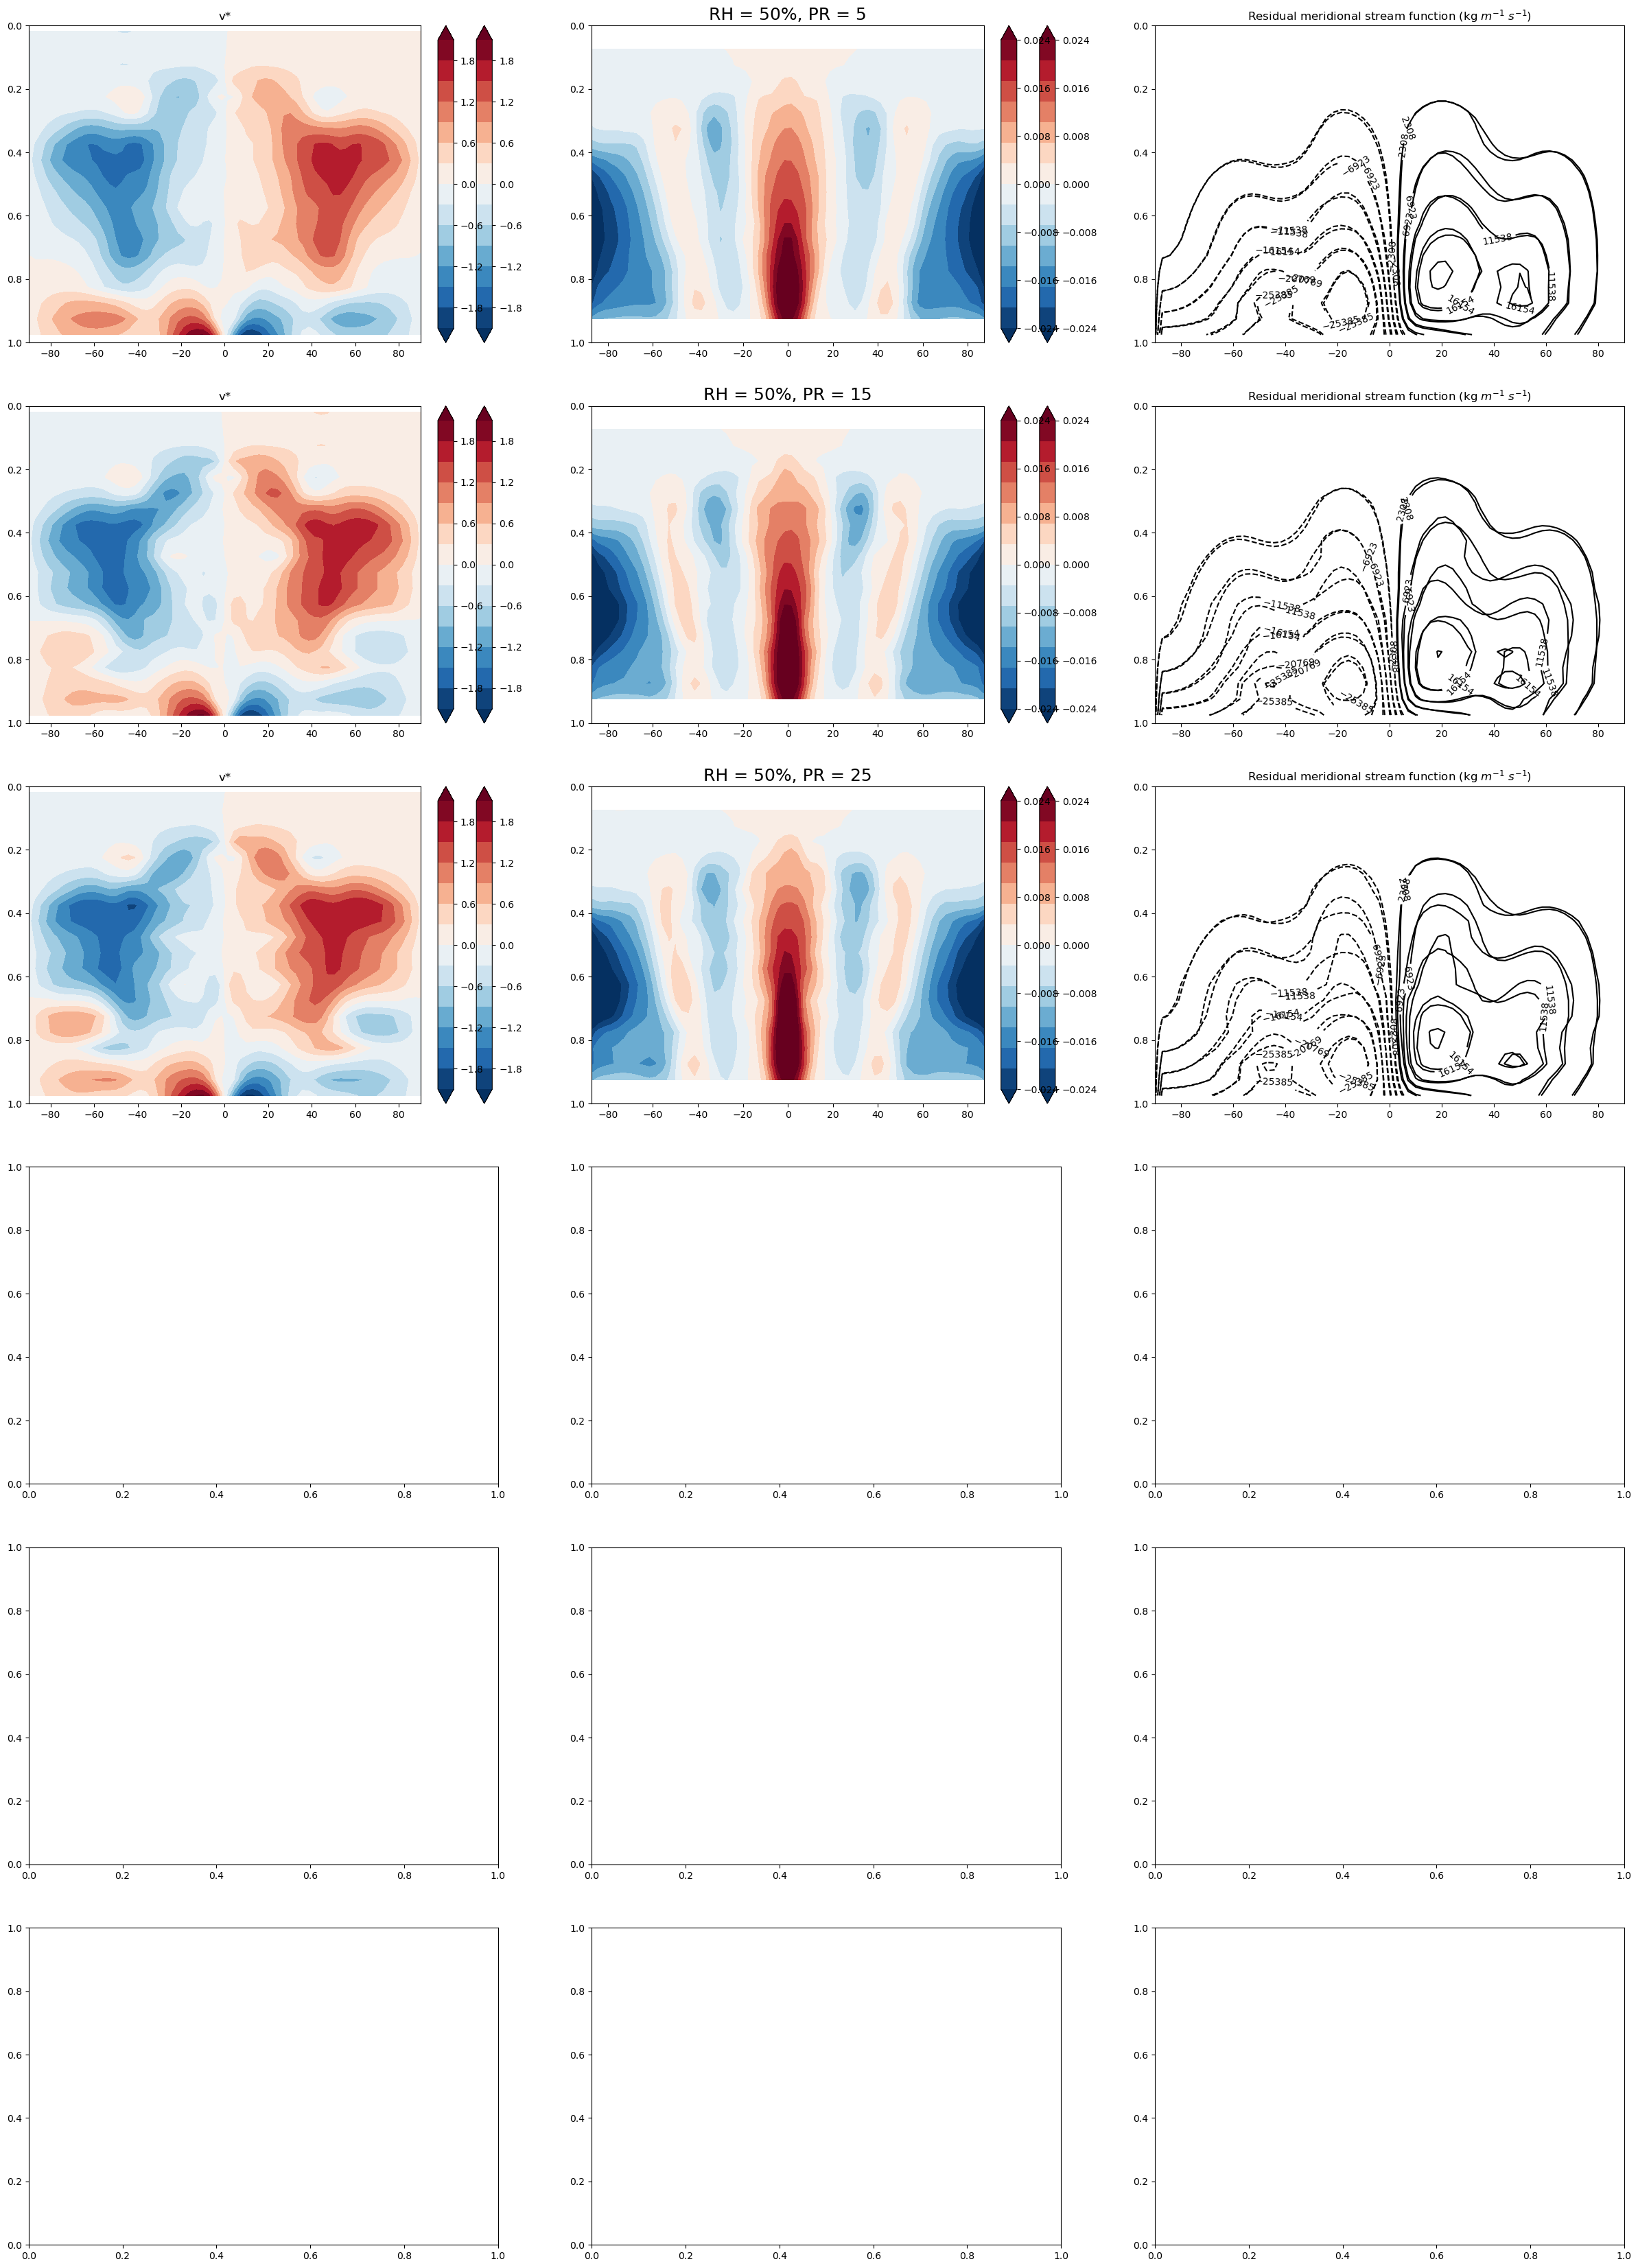

In [6]:
fig, ax = plt.subplots(6, 3, figsize=(30, 42))
for pr in range(0,30,5):
    vTEM, wTEM,p, ps, Wzmtm, rho_0 = plot_V_W_50(pr)
    sigma_mean = np.nanmean(p/ps, axis=(0,3))
    sigma_onlyz = np.nanmean(sigma_mean, axis=1)
    y = np.linspace(-90,90,64)
    yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
    ### residual circulation
    # phi
    a = 6.37122e6
    lat   = np.linspace(-90, 90, 64)
    phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
    cphi  = np.cos(phi) 
    acphi = a * cphi

    psi_w1 = Wzmtm #np.nanmean(w , axis=(0,3))
    psi_w2 = Wzmtm #np.nanmean(w , axis=(0,3))

    psi_w1[:,0] = 0
    for ilat in range(1,64-1):
        dlat = phi[:,ilat] - phi[:,ilat-1]       
        psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * (wTEM)[:,ilat])
        # print(psi_w1[:,ilat])

    psi_w2[:,64-1] = 0    
    for jlat in range(1,64-1):
        ilat = 64 - 1 - jlat
        dlat = phi[:,ilat] - phi[:,ilat+1]           
        psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * rho_0[:,ilat] * acphi[:,ilat] * (wTEM)[:,ilat])

    psi_w = 0.5*(psi_w1 + psi_w2)
    ####

    # plot
    print(int(pr/10))
    ### v*
    cs1 = ax[int(pr/10),0].contourf(yy[:,:], sigma_mean2[:,:], vTEM[:,:], levels=np.linspace(-2.1,2.1,15), cmap="RdBu_r", extend="both")
    ax[int(pr/10),0].set_ylim([1,0])
    fig.colorbar(cs1, orientation='vertical', ax=ax[int(pr/10),0],fraction=0.046, pad=0.04)
    ax[int(pr/10),0].set_title("v*")
    ###. w*
    cs2 = ax[int(pr/10),1].contourf(yy[1:-1,1:-1], sigma_mean2[1:-1,1:-1],-wTEM[1:-1,1:-1], levels=np.linspace(-2.4E-2,2.4E-2,15), cmap="RdBu_r", extend="both")
    ax[int(pr/10),1].set_ylim([1,0])
    cb2 = fig.colorbar(cs2, orientation='vertical', ax=ax[int(pr/10),1],fraction=0.046, pad=0.04)
    cb2.set_ticks(np.linspace(-2.4E-2,2.4E-2,7))
    ax[int(pr/10),1].set_title("w*")
    ### plot residual
    cs3 = ax[int(pr/10),2].contour(yy,sigma_mean2, -psi_w, levels=np.linspace(-30000,30000,14), colors='k')
    # print(np.nanmax(psi_w), np.nanmin(psi_w))
    ax[int(pr/10),2].clabel(cs3)
    ax[int(pr/10),2].set_ylim([1,0])
    ax[int(pr/10),2].set_title("Residual meridional stream function (kg $m^{-1}$ $s^{-1}$)") #(kg $m^{-1}$ $s^{-1}$) (RH=50, PR=10)
    ax[int(pr/10),1].set_title(f"RH = 50%, PR = {pr}", fontsize=18)
plt.show()

### cal cross spectrum

In [7]:
start = datetime.datetime.now()
# file  = f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"
file  = "800day_HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

dycore = Dycore(file)
# u   = dycore.getVar("grid_u_c_xyzt")
# u, Uza, Vza, yy, sigma_mean2, THETAza = dycore._cal_basic()
Mzm, dmdy     = dycore._cal_EMF_and_EMF_div()
# bza, f0       = dycore._cal_buoyancy_and_f0()
# z_new, theta_new = dycore._extrapolate_z_and_theta()
# # N_square = dycore._cal_N_square()



In [8]:
yy, sigma_mean2 = dycore._cooridate()
q2, MHF, MHF_f, z_new, theta_new= dycore.cal_q2()
end = datetime.datetime.now()
time = end - start
print(time)    

extrapolate done!
0:08:20.227832


In [9]:
file  = "800day_HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

dycore = Dycore(file)
z = dycore._cal_z()
print(z.shape)
# file  = "800day_HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

global_cross_spectrum_edit_EOF_back_usingT = Global_cross_spectrum_edit_EOF_back_usingT(file, MHF, MHF_f, z_new, theta_new, z, q2, dmdy)
v_star = global_cross_spectrum_edit_EOF_back_usingT._cal_basic2()
_, __, EOF_back = global_cross_spectrum_edit_EOF_back_usingT._cal_EOF()  


(800, 20, 64, 128)


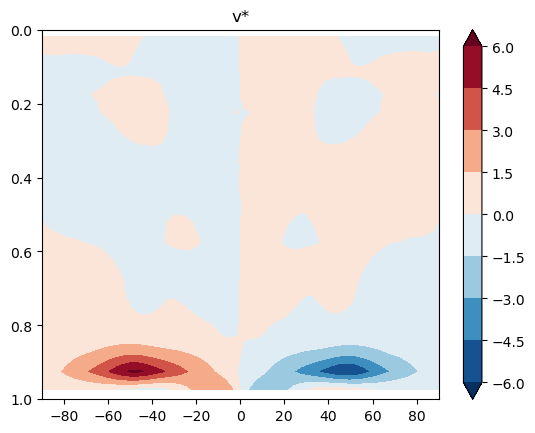

In [10]:
plt.figure()
plt.contourf(yy, sigma_mean2,  np.nanmean(v_star, axis=0), levels=11, cmap="RdBu_r", extend="both")
plt.ylim([1,0])
# plt.yscale('log')
# plt.gca().invert_yaxis()
plt.colorbar()
plt.title("v*")
plt.show()



## Cal $\overline{v}$ and $\overline{v^*}$ vertically integration,
### where $\overline{v}$ should be 0
### where $\overline{v^*}$ should NOT be 0

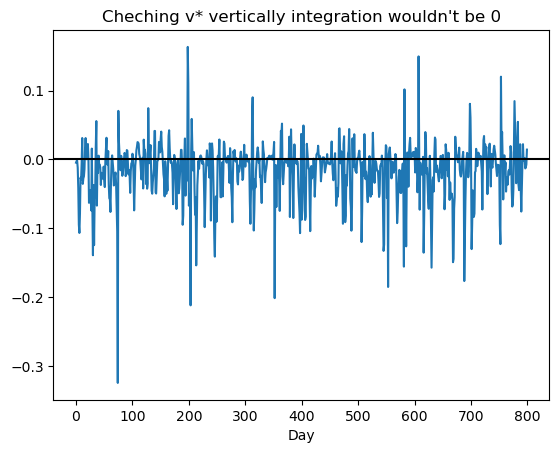

In [11]:
### check v* vertically integrate if is =0
v_star_new = np.zeros(v_star.shape)
v_star_vertical_integrate = np.nanmean(v_star, axis=(1))
v_star_final = np.zeros(800)
plt.figure()
plt.title("Cheching v* vertically integration wouldn't be 0")
for i in range(800):
    for j in range(64):
        v_star_final[i] = np.nansum(v_star_vertical_integrate[i,j])
plt.plot(v_star_final)
plt.axhline(y=0, color='k')
plt.xlabel("Day")
plt.show()

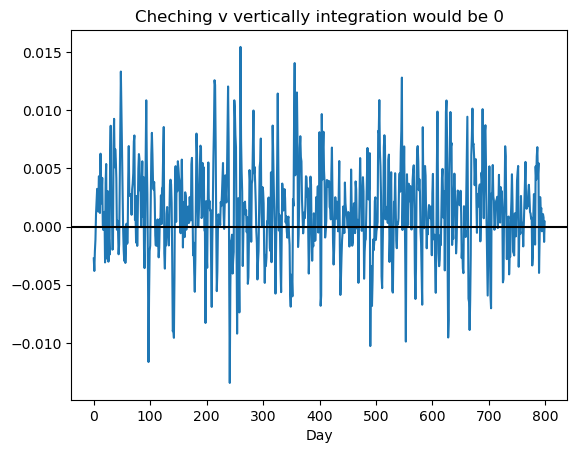

In [12]:
### check v vertically integrate if is =0
file  = "800day_HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
dycore = Dycore(file)

v  = dycore.getVar("grid_v_c_xyzt")
v_mean = np.nanmean(v, axis=3)
v_new = np.zeros(v_mean.shape)
v_vertical_integrate = np.nanmean(v_mean, axis=(1))
v_final = np.zeros(800)
for i in range(800):
    for j in range(64):
        v_final[i] = np.nansum(v_vertical_integrate[i,j])
plt.figure()
plt.title("Cheching v vertically integration would be 0")
plt.plot(v_final)
plt.axhline(y=0, color='k')
plt.xlabel("Day")
plt.show()

## Cal precipitation and and climate diagnosis

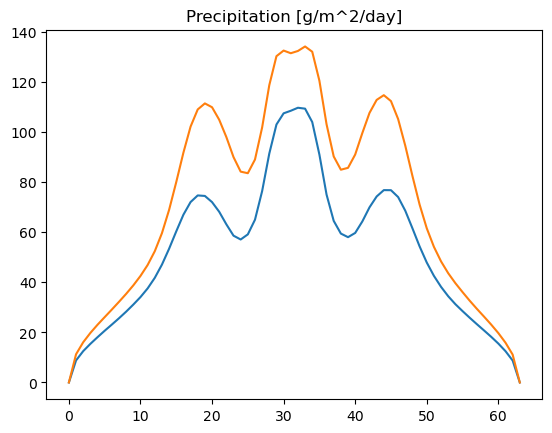

In [13]:
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan
file  = "HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
file2  = "800day_HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

dycore = Dycore(file)




def from_qv_to_p(file):
    dycore = Dycore(file)
    
    qv_diff = dycore.getVar("grid_tracers_diff_xyz1t")
    t       = dycore.getVar("grid_t_c_xyzt")
    
    qv_diff_sum = np.nansum(qv_diff[:,:,:,:], axis=(0,3))
    qv_diff_sum_new = np.zeros(qv_diff_sum.shape)
    pre = np.zeros((20,64))
    rho             = np.zeros((20,64))
    
    p_mean = np.nanmean(p, axis=(0,3))
    t_mean = np.nanmean(t, axis=(0,3))
    
    z_mean = np.nanmean(z, axis=(0,3))
    
    for i in range(1,64-1):
        qv_diff_sum_new[:,i] = qv_diff_sum[:,i] * cy[i]**0.5
    for i in range(1,64-1):
        rho[:,i] = p_mean[:,i] / 287 / t_mean[:,i] 

    for i in range(64):
        pre[:,i] = qv_diff_sum_new[:,i] * rho[:,i]
    pre_final = np.nansum(pre,axis=0)
    return pre_final

pre = from_qv_to_p(file)
pre2 = from_qv_to_p(file2)

plt.figure()
plt.plot(pre)
plt.plot(pre2)
plt.title("Precipitation [g/m^2/day]")
plt.show()

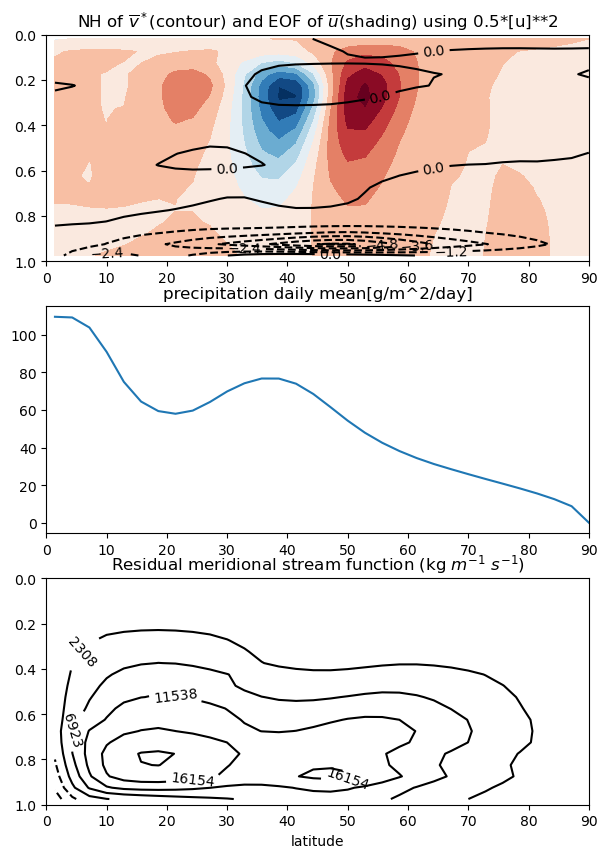

In [14]:
fig, ax = plt.subplots(3, dpi=100., figsize=(7,10))

# ax0 = plt.subplot2grid((1, 8), (0, 0), colspan=12)
# ax1 = plt.subplot2grid((2, 8), (1, 0), colspan=12)

ax[0].set_title("NH of $\overline{v}^*$(contour) and EOF of $\overline{u}$(shading) using 0.5*[u]**2")

CS = ax[0].contourf(yy[:,32:], sigma_mean2[:,32:],  EOF_back[:,32:], levels=11, cmap="RdBu_r", extend="both")
# fig.colorbar(CS)
ax[0].set_ylim([1,0])
CS = ax[0].contour(yy[:,32:], sigma_mean2[:,32:],  np.nanmean(v_star, axis=(0))[:,32:], levels=np.linspace(-6,6,11), colors='k')
plt.clabel(CS)
ax[0].set_ylim([1,0])
ax[0].set_xlim([0,90])

#
ax[1].plot(yy[0,32:], pre[32:])
ax[1].set_title("precipitation daily mean[g/m^2/day]")
# ax[1].plot(lat_0, qv_results[14,:] * int(pr/5) / 500)
cs3 = ax[2].contour(yy[:,32:],sigma_mean2[:,32:], -psi_w[:,32:], levels=np.linspace(-30000,30000,14), colors='k')
ax[1].set_xlim([0,90])

# print(np.nanmax(psi_w), np.nanmin(psi_w))
ax[2].clabel(cs3)
ax[2].set_ylim([1,0])
ax[2].set_title("Residual meridional stream function (kg $m^{-1}$ $s^{-1}$)") #(kg $m^{-1}$ $s^{-1}$) (RH=50, PR=10)
ax[2].set_xlabel("latitude")
# ax[2].set_title(f"RH = 50%, PR = {pr}", fontsize=18)
ax[2].set_xlim([0,90])

plt.show()


## Checking meridional temperrature gradient

In [15]:
class Cal_vb:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        
        self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        self.Uzm   = np.nanmean(self.u, axis=3)
        self.Vzm   = np.nanmean(self.v, axis=3)
        self.THzm  = np.nanmean(self.theta, axis=3)
        self.Pzm   = np.nanmean(self.p, axis=3)
        self.Tzm   = np.nanmean(self.t, axis=3)
        
        ### anamoly
        self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        self.THzmtm = np.nanmean(self.THzm, axis=0)
        self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        self.Vza     = np.zeros(self.u.shape)
        self.Uza     = np.zeros(self.u.shape)
        self.THETAza = np.zeros(self.u.shape)
        self.Pza     = np.zeros(self.u.shape)
        self.Tza     = np.zeros(self.t.shape)

        for i in range(0,128):
            self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
            self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
            self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
            self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
            self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan
        
    def getvTHETAza(self):
        self.vpTHETAzap = self.Vza * self.THETAza
        return np.nanmean(self.vpTHETAzap, axis=3)
    
    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def _get_len_day(self, var):
        return int(len(var[:,0,0,0]))
    
    def _cooridate(self):
        return self.yy, self.sigma_mean2
    
    def _cal_buoyancy_and_f0(self):
        # self.u, self.Uza, self.Vza, self.yy, self.sigma_mean2, self.THETAza =  self._cal_basic() 
        # self.yd  = self._cooridate()
        
        self.bza = self.THETAza / np.nanmean(self.theta, axis=0) * 9.81
        self.f0  = 2 * 7.292E-5 * np.sin(self.yd)
        return self.bza, self.f0
    
    def _cal_MHF_and_MHF_f(self):
        self.bza, self.f0    = self._cal_buoyancy_and_f0()
        self.vpbp = np.nanmean(self.Vza * self.bza, axis=3)

        return self.vpbp

### Using $\overline{v'b'}$

0
5
10
15
20
25


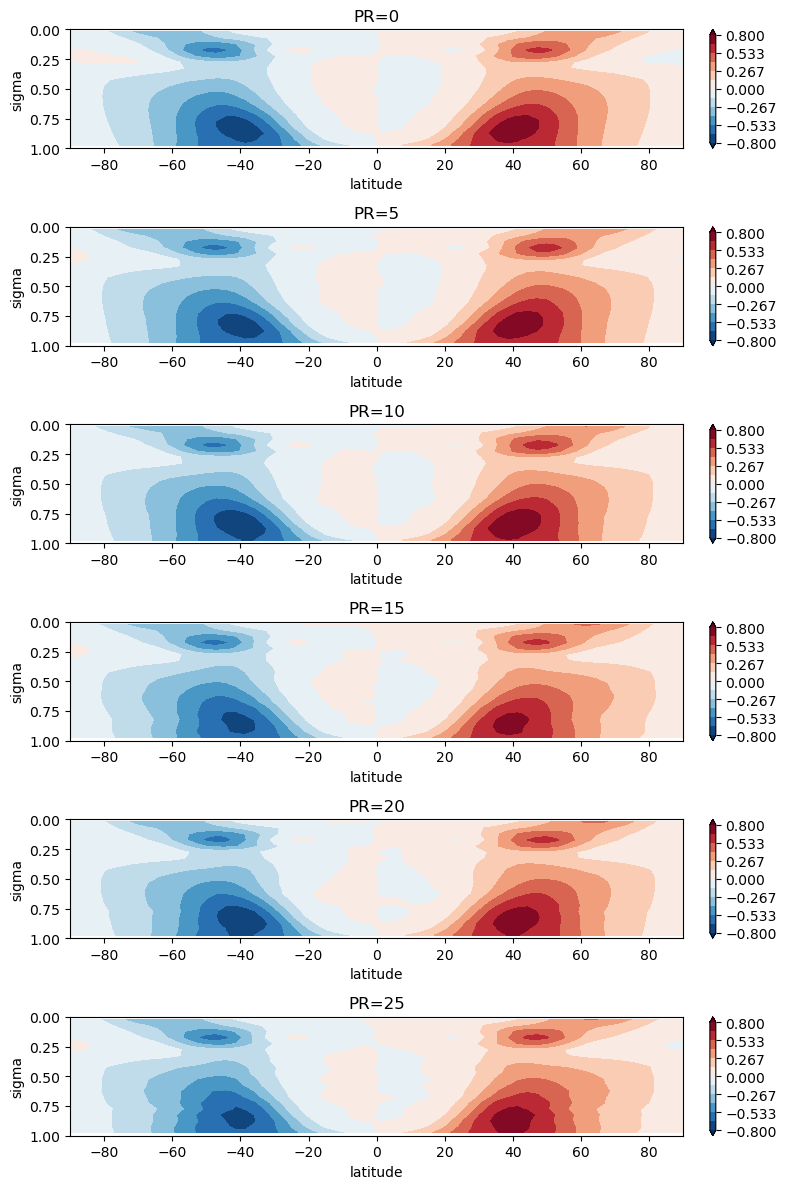

(800, 20, 64)


In [16]:
fig, ax = plt.subplots(6, figsize=(8,12), dpi=100.)
plt.title("$\overline{v'b'}$")

a = 0
for pr in range(0,30,5):
    print(pr)
    file  = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    cal_vb = Cal_vb(file)
    vb = cal_vb._cal_MHF_and_MHF_f()
    CS = ax[int(a)].contourf(yy, sigma_mean2,  np.nanmean(vb, axis=0), levels=np.linspace(-0.8,0.8,13), cmap="RdBu_r", extend="both")
    fig.colorbar(CS, orientation='vertical', ax=ax[a],fraction=0.046, pad=0.04)
    ax[int(a)].set_ylim([1,0])
    ax[int(a)].set_ylabel("sigma")
    ax[int(a)].set_xlabel("latitude")
    ax[int(a)].set_title(f"PR={pr}")
    a += 1
plt.tight_layout()
plt.show()
print(vb.shape)

In [17]:
# plt.figure(figsize=(8,6), dpi=100.)
plt.title("$\overline{v'b'}$")

a = 0
vb    = np.zeros((((6, 500, 20, 64))))
vb_vm = np.zeros((6,64))

for pr in range(0,30,5):
    print(pr)
    file  = f"HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    cal_vb = Cal_vb(file)
    
    vb[a,:,:,:] = cal_vb._cal_MHF_and_MHF_f()
    # max_lev = np.argmax(np.nanmean(vb[a,400:,:,:], axis=(0,2)))
    # print(max_lev)
    vb_vm[a,:] = np.nanmean(vb[a,400:,:6,:], axis=(0,1))
    print(np.nanmax(vb_vm[a,:]))
    a += 1


0
0.3536544153952207
5
0.376151688835371
10
0.37630216476358924
15
0.37518800595557944
20
0.4072775193604984
25
0.321975337034886


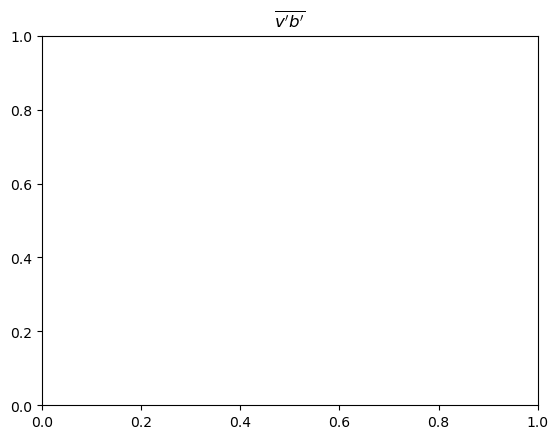

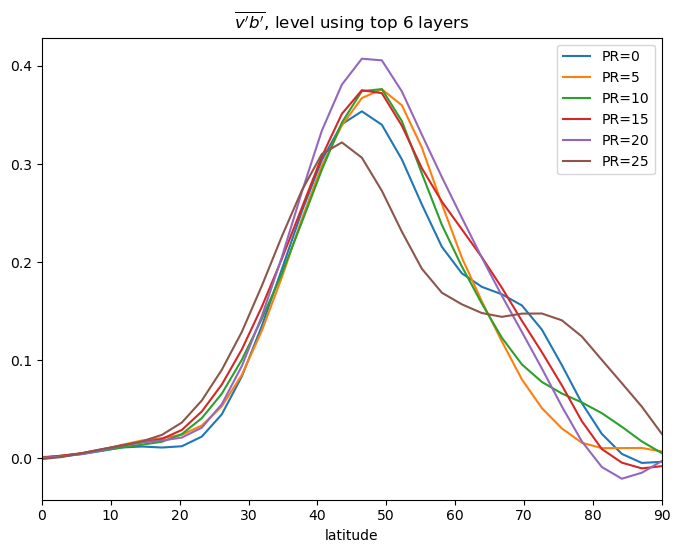

(6, 500, 20, 64)


In [18]:
plt.figure(figsize=(8,6), dpi=100.)
plt.title("$\overline{v'b'}$, level using top 6 layers")
a = 0
x = np.linspace(0,90,32)
for pr in range(0,30,5):
    plt.plot(x, vb_vm[a,32:], label=f"PR={pr}")
    a += 1
plt.xlabel("latitude")
plt.xlim([0,90])
plt.legend()
plt.show()
print(vb.shape)

(6, 500, 20, 64)


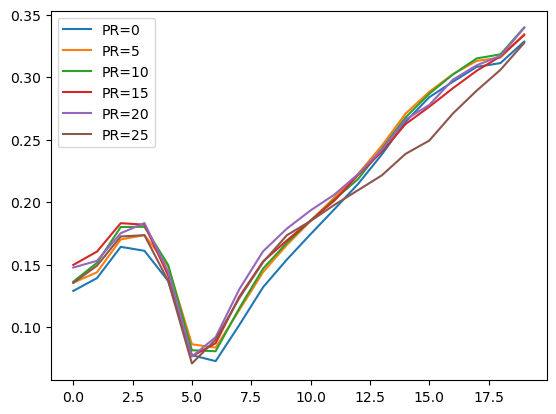

In [19]:
print(vb.shape)
vb_mean = np.nanmean(vb[:,:,:,32:], axis=(1,3))
# print(vb_mean)
plt.figure()
a = 0
for pr in range(0,30,5):
    plt.plot(vb_mean[a,:], label=f"PR={pr}")
    a += 1
plt.legend()
plt.show()

### Using ${\partial T \over \partial y}$

In [20]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        
    def getVar(self, var):
        return np.asarray(self.ds[var])

In [21]:
file  = "800day_HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat"
ds = h5py.File(file, "r")

In [22]:
dycore = Dycore(file)
t = dycore.getVar("grid_t_c_xyzt")
ps = dycore.getVar("grid_ps_xyzt")
p  = dycore.getVar("grid_p_full_xyzt")

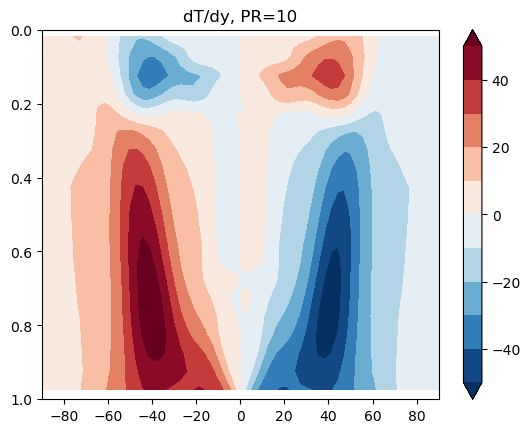

In [23]:
y  = np.linspace(-90,90,64)
yd = np.deg2rad(y)
dtdy = np.zeros((20,64))
t_mean = np.nanmean(t[:,:,:,:], axis=(0,3))

for i in range(1,64-1):
    dtdy[:,i] = (t_mean[:,i+1] - t_mean[:,i-1]) / (yd[i+1] - yd[i-1])
sigma_mean           = np.nanmean(p/ps, axis=(0,3))
sigma_onlyz          = np.nanmean(sigma_mean, axis=1)
y                    = np.linspace(-90,90,64)
yy, sigma_mean2 = np.meshgrid(y,sigma_onlyz)
plt.figure(dpi=100.)
plt.contourf(yy, sigma_mean2, dtdy,levels=11, cmap="RdBu_r", extend="both")
plt.colorbar()
plt.ylim([1,0])
plt.title("dT/dy, PR=10")
plt.show()

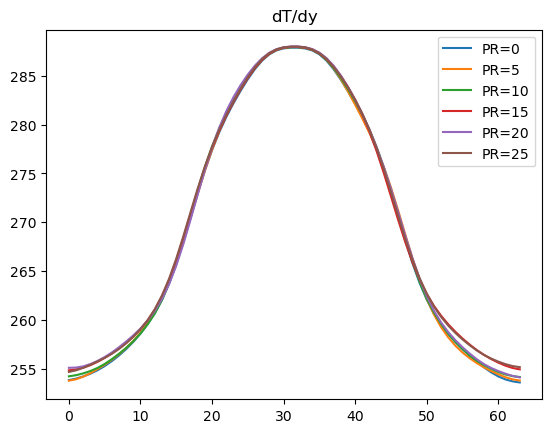

In [24]:
plt.figure(dpi=100.)
def cal_dtdy():
    for pr in range(0,30,5):
        file   = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"
        ds     = h5py.File(file, "r")   
        dycore = Dycore(file)
        t      = dycore.getVar("grid_t_c_xyzt")
        t_mean = np.nanmean(t[:,10:,:,:], axis=(0,1,3))
        plt.plot(t_mean, label=f"PR={pr}")
    # plt.xlim([40,64])
    plt.title("dT/dy")
    plt.legend()
    plt.show()
gogo = cal_dtdy()


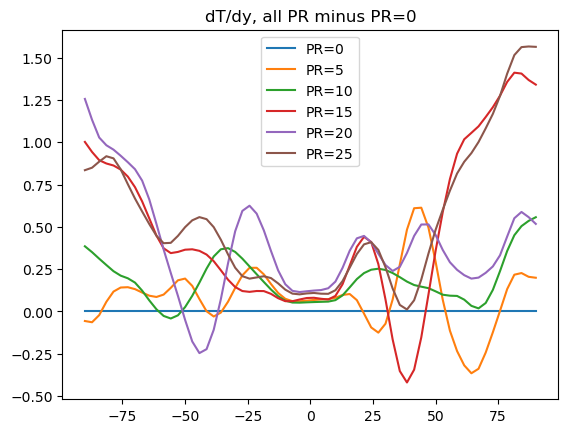

In [25]:
y  = np.linspace(-90,90,64)
yd = np.deg2rad(y)
dtdy = np.zeros((20,64))

plt.figure(dpi=100.)
def cal_dtdy():
    for pr in range(0,30,5):
        file0   = "800day_HS_front_RH50_PR0_PRRELAX86400_with_w_all.dat"
        file    = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"
        
        ds0     = h5py.File(file0, "r") 
        ds      = h5py.File(file, "r")   
        
        dycore0 = Dycore(file0)
        dycore  = Dycore(file)
        
        t0      = dycore0.getVar("grid_t_c_xyzt")
        t       = dycore.getVar("grid_t_c_xyzt")
        
        t0_mean = np.nanmean(t0[:,10:,:,:], axis=(0,1,3))
        t_mean  = np.nanmean(t[:,10:,:,:], axis=(0,1,3))
        
        plt.plot(y,(t_mean-t0_mean), label=f"PR={pr}")
    # plt.xlim([32,64])
    plt.title("dT/dy, all PR minus PR=0")
    # plt.xticks(y)
    plt.legend()
    plt.show()
gogo = cal_dtdy()

### Cal MSE

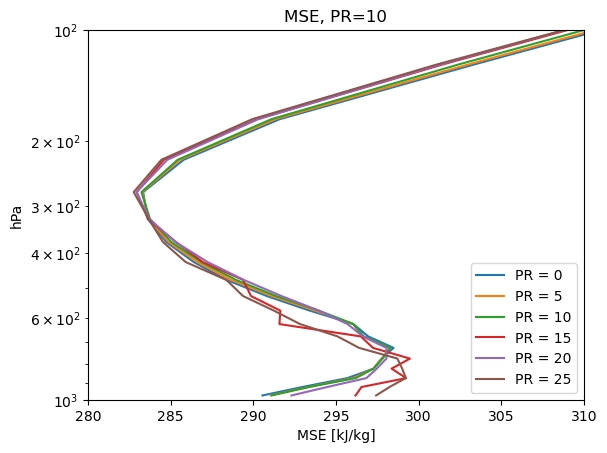

In [26]:
plt.figure(dpi=100.)
def cal_MSE():
    for pr in range(0,5,5):
        file  = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

        dycore = Dycore(file)
        u  = dycore.getVar("grid_u_c_xyzt")
        v  = dycore.getVar("grid_v_c_xyzt")
        t  = dycore.getVar("grid_t_c_xyzt")
        ps = dycore.getVar("grid_ps_xyzt")
        p  = dycore.getVar("grid_p_full_xyzt")
        qv = dycore.getVar("grid_tracers_c_xyz1t")

        p_mean = np.nanmean(p, axis=(0,2,3))
        sigma = p / ps
        sigma_mean = np.nanmean(sigma, axis=(0,3))
        sigma_onlyz = np.nanmean(sigma_mean, axis=1)
        Rd = 287
        cp = 1004
        g = 9.81
        Lv = 2.5E6
        ### cal z
        z = np.zeros(u.shape)
        for i in range(1,20-1):
            z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
        z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
        ###

        MSE = cp*t + g*z + Lv*qv

        final = np.nanmean(MSE, axis=(0,1,3))

        plt.plot(final/1000, label=f"PR = {pr}")
    plt.title("MSE, PR=10")
    # plt.yscale("log")
    # plt.gca().invert_yaxis()
    plt.legend()
    # plt.ylabel("hPa")
    # plt.xlabel("MSE [kJ/kg]")
    plt.ylim([1000,100])
    plt.xlim([280,310])
    
    plt.show()
    # return MSE, p_mean
gogo = cal_MSE()


### Cal d(MSE)/dy

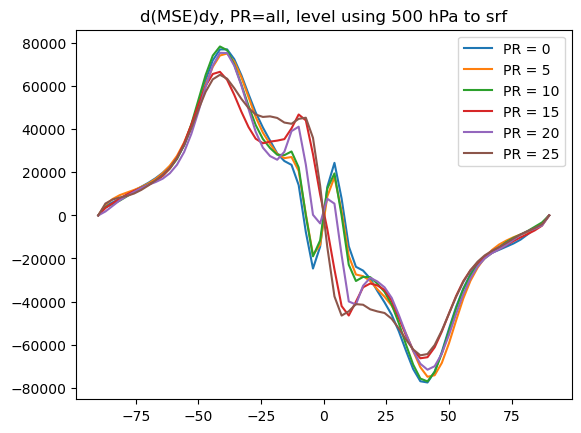

In [27]:
plt.figure(dpi=100.)
def cal_MSE():
    for pr in range(0,30,5):
        file  = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

        dycore = Dycore(file)
        u  = dycore.getVar("grid_u_c_xyzt")
        v  = dycore.getVar("grid_v_c_xyzt")
        t  = dycore.getVar("grid_t_c_xyzt")
        ps = dycore.getVar("grid_ps_xyzt")
        p  = dycore.getVar("grid_p_full_xyzt")
        qv = dycore.getVar("grid_tracers_c_xyz1t")

        p_mean = np.nanmean(p, axis=(0,2,3))
        sigma = p / ps
        sigma_mean = np.nanmean(sigma, axis=(0,3))
        sigma_onlyz = np.nanmean(sigma_mean, axis=1)
        Rd = 287
        cp = 1004
        g = 9.81
        Lv = 2.5E6
        ### cal z
        z = np.zeros(u.shape)
        for i in range(1,20-1):
            z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
        z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
        ###

        MSE = cp*t + g*z + Lv*qv

        MSE_mean = np.nanmean(MSE[:,10:,:,:], axis=(0,1,3))
        final = np.zeros(64)
        for i in range(1,64-1):
            final[i] = (MSE_mean[i+1] - MSE_mean[i-1]) / (yd[i+1] - yd[i-1])

        plt.plot(y, final, label=f"PR = {pr}")
    plt.title("d(MSE)dy, PR=all, level using 500 hPa to srf")
    # plt.yscale("log")
    plt.legend()
    # plt.xlabel("MSE [kJ/kg]")
    
    plt.show()
    # return MSE, p_mean
gogo = cal_MSE()


In [ ]:
plt.figure(dpi=100.)
def cal_MSE():
    for pr in range(0,30,5):
        file0  = "800day_HS_front_RH50_PR0_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
        file  = f"800day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/

        dycore0 = Dycore(file0)
        dycore = Dycore(file)
        
        u  = dycore.getVar("grid_u_c_xyzt")
        v  = dycore.getVar("grid_v_c_xyzt")
        t  = dycore.getVar("grid_t_c_xyzt")
        ps = dycore.getVar("grid_ps_xyzt")
        p  = dycore.getVar("grid_p_full_xyzt")
        qv = dycore.getVar("grid_tracers_c_xyz1t")
        
        u0  = dycore0.getVar("grid_u_c_xyzt")
        v0  = dycore0.getVar("grid_v_c_xyzt")
        t0  = dycore0.getVar("grid_t_c_xyzt")
        ps0 = dycore0.getVar("grid_ps_xyzt")
        p0  = dycore0.getVar("grid_p_full_xyzt")
        qv0 = dycore0.getVar("grid_tracers_c_xyz1t")

        p_mean = np.nanmean(p, axis=(0,2,3))
        sigma = p / ps
        sigma_mean = np.nanmean(sigma, axis=(0,3))
        sigma_onlyz = np.nanmean(sigma_mean, axis=1)
        Rd = 287
        cp = 1004
        g = 9.81
        Lv = 2.5E6
        ### cal z0
        z0 = np.zeros(u.shape)
        for i in range(1,20-1):
            z0[:,i,:,:] = Rd*np.nanmean(t0[:,0:i+1,:,:], axis=1)/g * np.log(ps0[:,0,:,:] / p0[:,i+1,:,:])
        z0[:, 0,:,:] = Rd*np.nanmean(t0[:,0: 1,:,:], axis=1)/g * np.log(ps0[:,0,:,:] / p0[:,1,:,:])
        z0[:,-1,:,:] = Rd*np.nanmean(t0[:,:,:,:], axis=1)/g * np.log(ps0[:,0,:,:] / p0[:,-1,:,:])
        ### cal z
        z = np.zeros(u.shape)
        for i in range(1,20-1):
            z[:,i,:,:] = Rd*np.nanmean(t[:,0:i+1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,i+1,:,:])
        z[:, 0,:,:] = Rd*np.nanmean(t[:,0: 1,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,1,:,:])
        z[:,-1,:,:] = Rd*np.nanmean(t[:,:,:,:], axis=1)/g * np.log(ps[:,0,:,:] / p[:,-1,:,:])
        ###

        MSE0 = cp*t0 + g*z0 + Lv*qv0
        MSE  = cp*t + g*z + Lv*qv
        

        MSE0_mean = np.nanmean(MSE0, axis=(0,1,3))
        MSE_mean  = np.nanmean(MSE, axis=(0,1,3))
        
        final0 = np.zeros(64)
        final  = np.zeros(64)
        
        for i in range(1,64-1):
            final0[i] = (MSE0_mean[i+1] - MSE0_mean[i-1]) / (yd[i+1] - yd[i-1])
            final[i]  = (MSE_mean[i+1] - MSE_mean[i-1]) / (yd[i+1] - yd[i-1])
            

        plt.plot(y, (final - final0), label=f"PR = {pr}")
    plt.title("d(MSE)dy minus PR0")
    # plt.yscale("log")
    plt.legend()
    # plt.xlabel("MSE [kJ/kg]")
    
    plt.show()
    # return MSE, p_mean
gogo = cal_MSE()
